In [1]:
# ! pip install transformers
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer

import torchsummary as summary
from tqdm import tqdm

from torch import nn
import torch.nn.functional as F
from transformers import RobertaModel

from sklearn.model_selection import train_test_split
import torch

import pandas as pd
import numpy as np
import os
import base64
import gc
import glob, os

from torch.optim import Adam
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\hp\miniconda3\envs\tf_gpu\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def create_onedrive_directdownload(onedrive_link):
    data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
    data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
    return resultUrl

In [3]:
onedrive_link='https://1drv.ms/u/s!AoiE7xOoBAsngsgx2HKIw1RxUnATTg?e=XsxZGD'
onedrive_direct_link=create_onedrive_directdownload(onedrive_link)
onedrive_direct_link
df=pd.read_csv(onedrive_direct_link)
df.drop('Unnamed: 0',axis=1,inplace=True)
df=df[['news_content','rule_labels_comb']]
df=df[~df['rule_labels_comb'].isna()]
df=df[(df['rule_labels_comb'].apply(len)!=2)]
df = df.reset_index()
del df['index']
df

,news_content,rule_labels_comb
0,Berenberg Bank analysts have provided a buy ra...,"['guidelines', 'market']"
1,"The article states that Berenberg, a German in...",['guidelines']
2,"In their analysis on October 30, 2023, experts...","['legal', 'guidelines']"
3,"Berenberg Bank has issued a \""buy\"" recommenda...","['legal', 'guidelines']"
4,The private bank Berenberg has upgraded its ra...,"['legal', 'statements', 'guidelines']"
...,...,...
10320,INTERVIEW Interview with Les Échos Interview w...,"['legal', 'sanctions', 'statements', 'guidelin..."
10321,UBS's latest Investor Watch report reveals tha...,"['legal', 'reports', 'guidelines']"
10322,SNB erwartet für 2021 Jahresgewinn von rund 26...,"['legal', 'reports', 'guidelines']"
10323,0:00 News A cryptocurrency exchange in Hong Ko...,"['legal', 'sanctions', 'reports', 'statements'..."


In [4]:
from ast import literal_eval
df['rule_labels_comb'] = df['rule_labels_comb'].apply(literal_eval)
df['target']='[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]'
df['target'] = df['target'].apply(literal_eval)

df['target'].iloc[0][0]

0.0

In [5]:

for index, value in df['rule_labels_comb'].iteritems():
    class_dic={'legal':0,'sanctions':1,'papers':2,'reports':3,'statements':4,'guidelines':5,'press':6,'personnel':7,'market':8}
    val=[class_dic.get(i, i) for i in value]
    df['rule_labels_comb'].iloc[index]=val
    y=0
    for x in df['rule_labels_comb'].iloc[index]:
        df['target'].iloc[index][x]=1.0
        y=y+1
df['rule_labels_comb']

0                 [5, 8]
1                    [5]
2                 [0, 5]
3                 [0, 5]
4              [0, 4, 5]
              ...       
10320    [0, 1, 4, 5, 8]
10321          [0, 3, 5]
10322          [0, 3, 5]
10323    [0, 1, 3, 4, 5]
10324    [0, 1, 3, 4, 5]
Name: rule_labels_comb, Length: 10325, dtype: object

In [6]:
df['target']

0        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
1        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
2        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
3        [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
4        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
                             ...                      
10320    [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]
10321    [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
10322    [1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
10323    [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
10324    [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Name: target, Length: 10325, dtype: object

In [7]:
# import data from gdrive
'''
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/')


df=pd.read_csv('BERT_data.csv')
df=df[~(df['content']=='nan')]
df['content']=df['content'].astype(str)
df['subject']=df['subject'].astype(str)
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nimport os\nos.chdir('/content/drive/My Drive/')\n\n\ndf=pd.read_csv('BERT_data.csv')\ndf=df[~(df['content']=='nan')]\ndf['content']=df['content'].astype(str)\ndf['subject']=df['subject'].astype(str)\n"

In [8]:
# change range of labels, minimum should be zero
df['rule_labels_comb']=df['rule_labels_comb'].astype(str)
df

,news_content,rule_labels_comb,target
0,Berenberg Bank analysts have provided a buy ra...,"[5, 8]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
1,"The article states that Berenberg, a German in...",[5],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"In their analysis on October 30, 2023, experts...","[0, 5]","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
3,"Berenberg Bank has issued a \""buy\"" recommenda...","[0, 5]","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
4,The private bank Berenberg has upgraded its ra...,"[0, 4, 5]","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
...,...,...,...
10320,INTERVIEW Interview with Les Échos Interview w...,"[0, 1, 4, 5, 8]","[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]"
10321,UBS's latest Investor Watch report reveals tha...,"[0, 3, 5]","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
10322,SNB erwartet für 2021 Jahresgewinn von rund 26...,"[0, 3, 5]","[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
10323,0:00 News A cryptocurrency exchange in Hong Ko...,"[0, 1, 3, 4, 5]","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]"


In [9]:
# additional filtering to balance classes
'''
df_3=df[(df['result']==3) & (df['content'].str.len()<350)]
df=df[~(df['result']==3)]
df=pd.concat([df,df_3])
df
'''

"\ndf_3=df[(df['result']==3) & (df['content'].str.len()<350)]\ndf=df[~(df['result']==3)]\ndf=pd.concat([df,df_3])\ndf\n"

In [10]:
# import BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
class Dataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.labels=df['target']
        self.text=[tokenizer(text,padding='max_length',truncation=True,return_tensors="pt") for text in df['news_content']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.text[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [11]:
# train test split
X_train, X_test= train_test_split(df[['news_content','target']], test_size=0.25)

In [12]:
df_train=X_train
df_val=X_test
df_test=0

In [13]:
df_train

,news_content,target
394,"The former CEO of M.M. Warburg bank, Kristians...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9288,An der Prognose für das Gesamtjahr hält die im...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
4042,"Dechra Pharmaceuticals, a U.K.-based veterinar...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4530,Les actions de Julius Baer ont chuté de 76% ap...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
10072,VW bringt Porsche möglicherweise noch dieses J...,"[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
...,...,...
5678,Shield Introduces Hybrid Cloud Solution For Fi...,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
5714,Wir sind erneut die #TopBank im #Cash Manageme...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2363,The article is a job listing from ZipRecruiter...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]"
5261,Diese traurige aber triviale Wahrheit hat durc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"


In [14]:
# BERT classifier architecture, with 7 output classes
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 9)
        torch.nn.init.kaiming_uniform_(self.linear.weight, nonlinearity='relu')
        self.relu = nn.ReLU()
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.text[idx]

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer


In [15]:
# change runtype to GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [16]:
# hyperparameters
EPOCHS = 100
model = BertClassifier()
LR = 0.00001

In [17]:
df_train=df_train.reset_index()
df_train.drop('index',axis=1,inplace=True)

df_val=df_val.reset_index()
df_val.drop('index',axis=1,inplace=True)
df_val

,news_content,target
0,"Laut Medienberichten hat die Credit Suisse, di...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,Aktien von Commerzbank Porsche und Infineon fü...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
2,The article discusses the ongoing battle for s...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
3,Deutsche Bank is reportedly planning to cut ar...,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
4,Hinter dem Verkauf großer Aktienpakete dürfte ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
...,...,...
2577,Seite 1: Die Commerzbank glaubt trotz eines dr...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2578,"The Bankhaus Metzler, a German private bank, h...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]"
2579,In den vergangenen Wochen haben viele Analyste...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2580,FRANKFURT (dpaAFX Analyser) Deutsche Bank (De...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"


In [18]:
# display BERT layers
n=0
for x in model.state_dict():
    n=n+1
    print(x)
n

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

201

In [19]:
# freeze first 8 layers 
n=0
for param in model.parameters():
    n=n+1
    param.requires_grad = False
    if n==(201-68):
        break

In [20]:
# change datatypes of input data
df_train['news_content']=df_train['news_content'].astype(str)

df_val['news_content']=df_val['news_content'].astype(str)
df_train['news_content'].iloc[0]

'The former CEO of M.M. Warburg bank, Kristians Oleariuss, appeared in a court in the German city of Bonn last month. This is just one of the cases related to the Cum-Ex tax scandal that has rocked Germany and several other European countries. Oleariuss and other individuals are accused of participating in a scheme that allowed multiple people to claim tax rebates on the same dividend. The scandal is estimated to have cost European countries billions of euros in lost tax revenue. The trial serves as a reminder of the ongoing legal battle surrounding the Cum-Ex scandal.'

In [22]:
torch.cuda.empty_cache()
gc.collect()

0

Epoch 1/100: 100%|████████████████████████████████████████████████████████| 259/259 [08:10<00:00,  1.89s/item, Epoch=1]


Epoch 2/100: 100%|████████████████████████████████████████████████████████| 259/259 [08:11<00:00,  1.90s/item, Epoch=2]


Epoch 3/100: 100%|████████████████████████████████████████████████████████| 259/259 [08:12<00:00,  1.90s/item, Epoch=3]


Epoch 4/100: 100%|████████████████████████████████████████████████████████| 259/259 [08:11<00:00,  1.90s/item, Epoch=4]


Epoch 5/100: 100%|████████████████████████████████████████████████████████| 259/259 [08:14<00:00,  1.91s/item, Epoch=5]


Epoch 6/100: 100%|████████████████████████████████████████████████████████| 259/259 [08:13<00:00,  1.91s/item, Epoch=6]


Epoch 7/100: 100%|████████████████████████████████████████████████████████| 259/259 [08:14<00:00,  1.91s/item, Epoch=7]


Epoch 8/100: 100%|████████████████████████████████████████████████████████| 259/259 [08:11<00:00,  1.90s/item, Epoch=8]


Epoch 9/100: 100%|████████████████████████████████████████████████████████| 259/259 [08:12<00:00,  1.90s/item, Epoch=9]


Epoch 10/100: 100%|██████████████████████████████████████████████████████| 259/259 [08:14<00:00,  1.91s/item, Epoch=10]


Epoch 11/100: 100%|██████████████████████████████████████████████████████| 259/259 [08:16<00:00,  1.92s/item, Epoch=11]


Epoch 12/100: 100%|██████████████████████████████████████████████████████| 259/259 [08:19<00:00,  1.93s/item, Epoch=12]


Epoch 13/100: 100%|██████████████████████████████████████████████████████| 259/259 [08:16<00:00,  1.92s/item, Epoch=13]


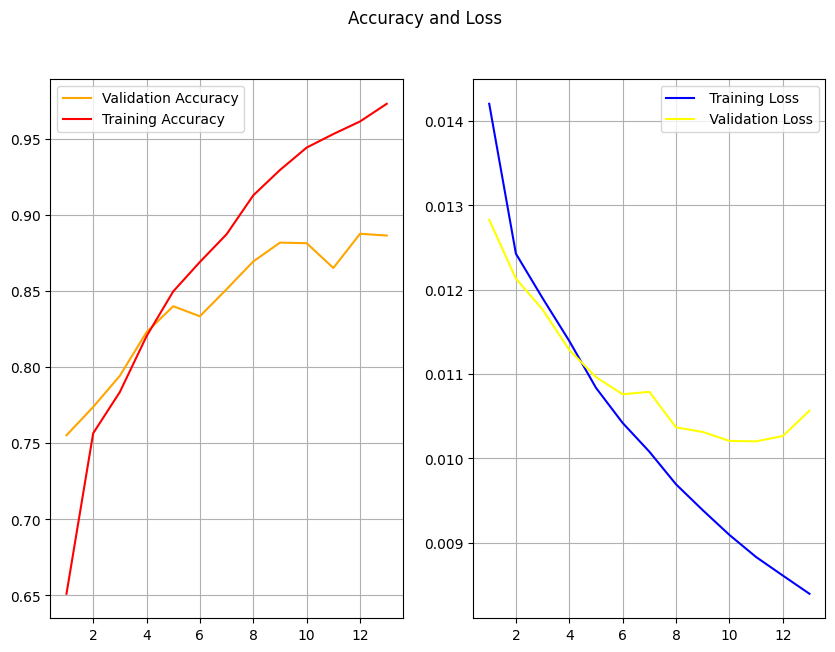

In [23]:
def train(model, train_data, val_data, learning_rate, epochs):
    
    stop_criteria=0
    
    train, val = Dataset(train_data), Dataset(val_data)
    
    # mini batching
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=30)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=30)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    
    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()
            
    plot_val_acc=[]
    plot_train_acc=[]
    plot_epoch=[]
    plot_train_loss=[]
    plot_val_loss=[]

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            true_acc=0
            n=0
            with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch_num + 1}/{epochs}', unit='item',position=0,leave=True) as p_bar:
                for train_input, train_label in train_dataloader:
                    train_label = train_label.to(device) # to cuda GPU
                    mask = train_input['attention_mask'].to(device) # attention mask
                    input_id = train_input['input_ids'].squeeze(1).to(device)

                    l1_loss=0

                    # for L1 regularization
                    a=0
                    reg_loss = 0
                    for param in model.parameters():
                        a=a+1
                        if a >=201-68:
                            reg_loss += torch.norm(param, 1) 
                    '''
                    factor = 0.00001 #lambda for L1 regularization
                    l1_loss=factor * reg_loss # L1 loss
                    '''
                    # model output
                    output = model(input_id, mask)


                    # loss value
                    batch_loss = criterion(output, train_label) + l1_loss
                    total_loss_train += batch_loss.item() 

                    # train accuracy 
                    output=output.squeeze(0)
                    train_label=train_label.squeeze(0)
                    # print(output)
                    # print(train_label)
                    # print(torch.gather(train_label, 1, torch.argmax(output,dim=1).view(-1, 1)))
                    acc = torch.gather(train_label, 1, torch.argmax(output,dim=1).view(-1, 1)).sum().item()
                    total_acc_train += acc
                    
                    # true accuracy
                    true_acc_batch=0
                    for (x,y) in zip(torch.round(F.sigmoid(output)*10)/10,train_label): # ceil or round
                        x=torch.tensor(x)
                        y=torch.tensor(y)
                        # print(x)
                        # print(y)
                        x[x<1]=0
                        true_acc=true_acc+torch.sum(x==y).item()
                        true_acc_batch=true_acc_batch+torch.sum(x==y).item()


                    # backpropogation
                    model.zero_grad()
                    batch_loss.backward()
                    optimizer.step()
                    p_bar.set_postfix(loss=batch_loss.item() / len(train_input['input_ids']), acc=acc / len(train_input['input_ids']), true_acc=true_acc_batch / (len(train_input['input_ids'])*9))
                    p_bar.update()
                p_bar.set_postfix({'Epoch': epoch_num + 1})
            # print(output)
            # print(train_label)

            total_acc_val = 0
            total_loss_val = 0
            true_val_acc=0
            
            # for validation accuracy
            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)
                    
                    # validation output
                    output = model(input_id, mask)
                    
                    # validation loss value
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                
                    # validation accuracy
                    output=output.squeeze(0)
                    val_label=val_label.squeeze(0)
                    acc = torch.gather(val_label, 1, torch.argmax(output,dim=1).view(-1, 1)).sum().item()
                    total_acc_val += acc
                    
                    # true accuracy
                    for (x,y) in zip(torch.round(F.sigmoid(output)*10)/10,val_label): # ceil or round
                        x=torch.tensor(x)
                        y=torch.tensor(y)
                        x[x<1]=0
                        true_val_acc=true_val_acc+torch.sum(x==y).item()
            
            print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f} \
            | True Train Accuracy: {true_acc / (len(train_data)*9): .3f} \
            | True Val Accuracy: {true_val_acc / (len(val_data)*9): .3f}',end='\r')
            
            plot_train_acc.append(total_acc_train / len(train_data))
            plot_val_acc.append(total_acc_val / len(val_data))
            plot_epoch.append(epoch_num + 1)
            plot_train_loss.append(total_loss_train / (len(train_data)*9))
            plot_val_loss.append(total_loss_val / (len(val_data)*9))
            
            # model checkpoint
            checkpoint = {
            'epoch': epoch_num+1,
            'model_state_dict': model.state_dict(),
            }
            
            torch.save(checkpoint, f'BERT_checkpoint_epoch{epoch_num+1}.pth')
            
            try:
                if plot_val_loss[-1]>plot_val_loss[-2] and plot_val_loss[-2]>plot_val_loss[-3]:
                    break
            except:
                pass
    
        
    fig, ax = fig,ax= plt.subplots(1, 2, figsize=(10, 7))
    fig.suptitle('Accuracy and Loss')
    
    
    
    ax[0].plot(plot_epoch,plot_val_acc, label='Validation Accuracy',color='orange')
    ax[0].plot(plot_epoch,plot_train_acc, label='Training Accuracy',color='red')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot(plot_epoch,plot_train_loss, label=' Training Loss',color='blue')
    ax[1].plot(plot_epoch,plot_val_loss, label=' Validation Loss',color='yellow')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.show()
    
    # retrieve best checkpoint model
    checkpoint = torch.load(f'BERT_checkpoint_epoch{epoch_num+1-2}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    
    # save best model
    torch.save(model, 'BERT_classifier.pth')
    
    # delete remaining model checkpoints
    for f in glob.glob("BERT_checkpoint*.pth"):
        os.remove(f)  
        
        
train(model, df_train, df_val, LR, EPOCHS)